In [ ]:
import os
import numpy as np
import random
from PIL import Image,ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Flatten,Dropout,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"]='/content'

In [ ]:
#!/bin/bash
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [ ]:
!unzip /content/brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
#directories for training and testing data
train_dir='/content/Training'
test_dir='/content/Testing'

#load and shuffle train data
train_paths=[]
train_labels=[]

for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir,label)):
    train_paths.append(os.path.join(train_dir,label,image))
    train_labels.append(label)

train_paths,train_labels=shuffle(train_paths,train_labels)


#load and shuffle test data
test_paths=[]
test_labels=[]

for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    test_paths.append(os.path.join(test_dir,label,image))
    test_labels.append(label)

test_paths,test_labels=shuffle(test_paths,test_labels)

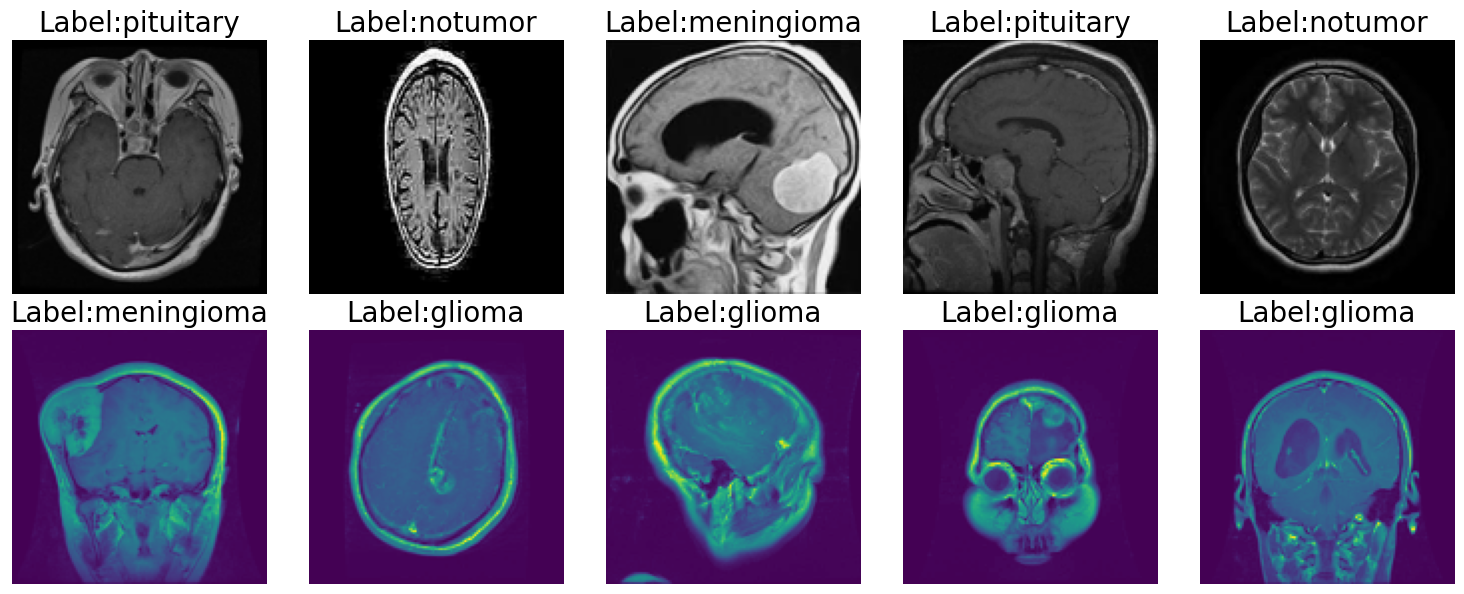

In [ ]:
#Data Visualization
import random
import matplotlib.pyplot as plt

#select random indices for 10 images
random_indices=random.sample(range(len(train_paths)),10)
random_indices

#create a figure to display images in 2 roes
fig,axes=plt.subplots(2,5,figsize=(15,6))
axes=axes.ravel()

#loop through the random indices and display images
for i,index in enumerate(random_indices):
  img_path=train_paths[index]
  img=Image.open(img_path)
  img=img.resize((128,128))

  #display
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f'Label:{train_labels[index]}',fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
#Image preprocessing
#image_augmentation funtion
def augment_image(image):
  image=Image.fromarray(np.uint8(image))
  image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image=ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image=np.array(image)/255.0
  return image

def open_images(paths):
  images=[]
  for path in paths:
    image=load_img(path,target_size=(IMAGE_SIZE,IMAGE_SIZE))
    image=augment_image(image)
    images.append(image)
  return np.array(images)


def encode_label(labels):
  unique_labels=os.listdir(train_dir)
  encoded=[unique_labels.index(label) for label in labels]
  return np.array(encoded)


def datagen(paths,labels,batch_size=12,epochs=1):
  for _ in range(0,len(paths),batch_size):
    batch_paths = paths[i:i + batch_size]
    batch_images = open_images(batch_paths)  # Open and augment images
    batch_labels = labels[i:i + batch_size]
    batch_labels = encode_label(batch_labels)  # Encode labels
    yield batch_images, batch_labels

MODEL:

In [11]:
#model architecture
IMAGE_SIZE=128
base_model=VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')

#freeze all layers of VGG16 base model
for layers in base_model.layers:
  layers.trainable=False

#set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

#build the final model
model=Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)),activation='softmax'))

#compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

#parameters
batch_size=20
steps=int(len(train_paths)/batch_size)
epochs=5

#train the model
history=model.fit(datagen(train_paths,train_labels,batch_size=batch_size,epochs=epochs),
                  epochs=epochs,steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - loss: 0.0972 - sparse_categorical_accuracy: 0.9603
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - loss: 4.5894e-06 - sparse_categorical_accuracy: 1.0000 
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 8.9414e-06 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 4.5004e-06 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 2.3109e-06 - sparse_categorical_accuracy: 1.0000


Train and Val Plots

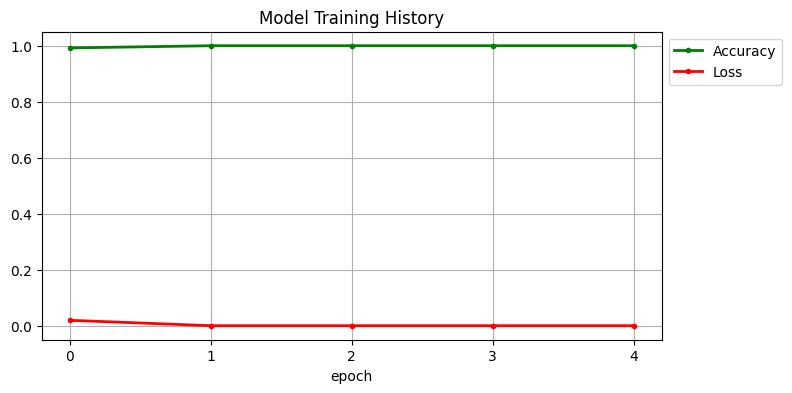

In [12]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Model Classification Report

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       306
           1       0.50      0.97      0.66       300
           2       0.88      0.84      0.86       405
           3       0.59      0.67      0.63       300

    accuracy                           0.63      1311
   macro avg       0.49      0.62      0.54      1311
weighted avg       0.52      0.63      0.56      1311



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Confusion Plot

Confusion Matrix:
[[  0 167  39 100]
 [  0 290   5   5]
 [  0  27 340  38]
 [  0  95   3 202]]


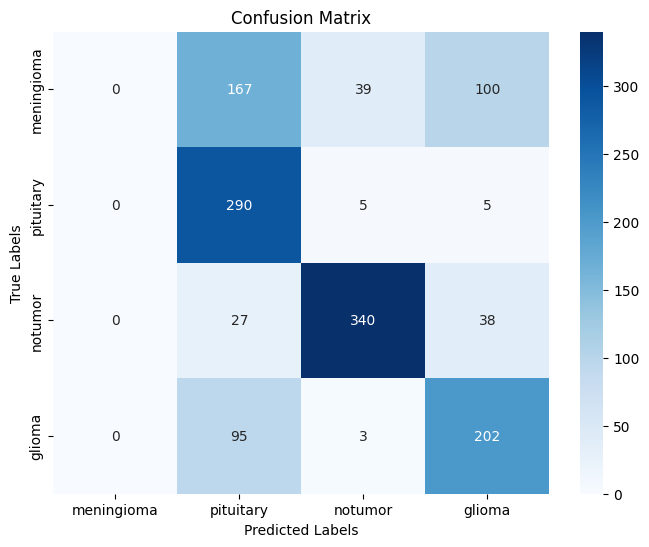

In [14]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Save & Load Model

In [15]:
model.save('model.h5')

In [16]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

MRI Tumor Detection System

In [17]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


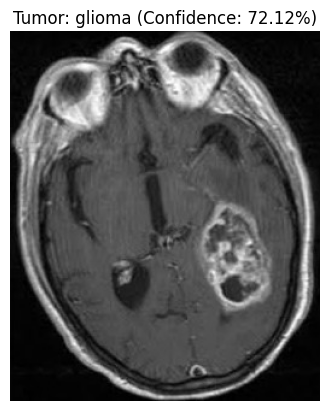

In [18]:
image_path = '/content/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


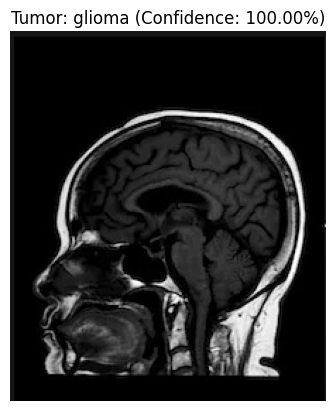

In [19]:
image_path = '/content/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


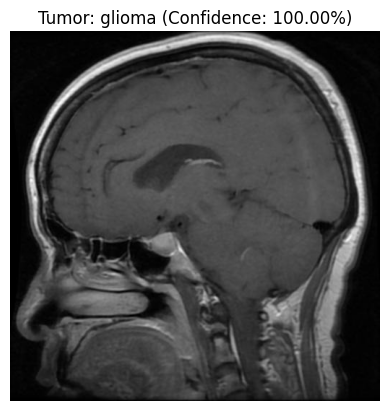

In [20]:
image_path = '/content/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


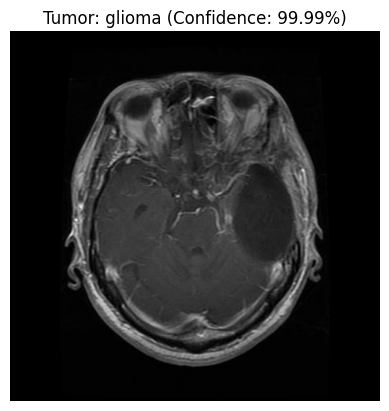

In [21]:
image_path = '/content/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)